# *<span style="color:springgreen">GAMALOS</span>* (GAlaxies MAking LOve Simulation)

In this project we run a simulation of an encounter between two disc galaxies using a simplified N-body realisation of a disc galaxy containing a central object that represents the total mass distribution of the galaxy, and a number of low-mass tracers for the stellar disc. Using the tracers we can follow the evolution of both the disc geometry and the kinematics and we can see how these are perturbed by the interactions between two galaxies, highlighting the creation of structures. 

This is just a simple simulation since disc galaxies are complex multi-components systems. A merge of this kind could produce clumps of dense cold gass clouds, favoring episodes of star formation. In fact it has been observed that interacting galaxies show an high rate of stellar formation. However this goes beyond the scope of our project. 

We will divide the project into 7 'Chapters':
1) Brief overview of the N-body problem and some theory about how to deal with collisionless simulations, and a short description of the Fireworks package and its implementation;
2) Overview of the GAMALOS project;
3) Stability of the disk representation;
4) Encounter between two galaxies rotating in the same direction and laying in the same plane;
5) Encounter between two galaxies rotating in opposite directions and laying in the same plane;
6) Encounter between two galaxies rotating in the same direction and laying in different planes;
7) Conclusions

# 1 - N-body

## The N-body problem

The N-body problem is the problem concerning the prediction of the motion of a group of objects interacting gravitationally with eachother. This puzzle is of paramount importance in astrophysics because is applied to a huge variety of astrophysical situations and scales (solar system, satellites, binary evolution, stars in a cluster or in a galaxy...). \
The N-body problem dates back to the XVII century when Isaac Newton came up with the intuition that two bodies with mass $m_1$ and $m_2$ at a distance $\vec{r}_{12}$ from eachother are subjected to a mutual force
$$
\begin{equation}
    \vec{F}_{1,2} = m_1 \vec{a}_1 = - G \frac{m_1 m_2}{r_{12}^2} \frac{ \vec{r}_{12} }{ r_{12} } .
\end{equation}\tag{1}
$$
Then, extending this to a system of N-body, the acceleration of the body $i$ due to all the other bodies is expressed by 
$$
\begin{equation}
    \frac{ d^2 \vec{x}_i } {dt^2} = - G \sum^N_{j=1, j\neq i} m_j \frac{ \vec{x}_i - \vec{x}_j }{ | \vec{x}_i - \vec{x}_j |^3  } .
\end{equation}\tag{2}
$$

It can be demonstrated that each N-body system has:
- 6 costants of motion (the position and the velocity of the centre of mass);
- 4 integrals of motion (the energy and the three components of the angular momentum).

It exists an analitic solution for $N=2$ (Bernoulli was the first to derive it in 1710). The complete solution for a generic number of bodies had not been found yet (in 1991 Qiudong Wang found a convergent power series solution for a generic number of bodies, but it is too difficult to implement and has a slow convergence). In fact, by simply adding a third particle the unknowns become 18, and the constants/integrals of motion are not enough to reduce the complexity of the problem. Then constrains have to be added in order to achieve an analitic solution, and this analitic solution is known only for a small amount of cases (e.g. circular restricted three body problem). Therefore, numerical methods are used in order to integrate this system of differential equations. 

Another important thing to point out is the numerical complexity of this problem, which is nothing more than the number of computations (numerical iterations) required to complete the task. In the case examined the time complexity is $O(N^2)$: it grows rapidly as N increases, and this represents a major problem to overcome when building a model to describe the system. 

## N-body units

N-body units are a very powerful and useful method when dealing with the N-body problem. They represent a convenient set of units for N-body simulations, based on the assumption that $G = 1$. \
The conversion to physical values can be done a-posteriori, inserting eventually some typical values of the astrophysical system of interest. \
It must be kept in mind that this treatment fails when adding to the simulation data about stars' proper mass and radius, or stellar evolution, or SN explosion, or when setting additional fields in order to reproduce a certan galactic physical configuration; on the other hand, when stars are considered as abstract point mass particles, the scale invariance of the N-body simulation can be exploited.

In order to convert N-body units into physical units a scale lenght $L_{scale}$ and a scale mass $M_{scale}$ need to be defined. Then:
$$
\begin{equation}
    T_{scale} = \sqrt{  \frac{L_{scale}^3}{G M_{scale}}   }   ,
\end{equation}\tag{3}
$$
$$
\begin{equation}
    V_{scale} = \frac{L_{scale}}{T_{scale}} = \sqrt{  \frac{G M_{scale}}{L_{scale}}   } ,
\end{equation}\tag{4}
$$
and from here physical units can be recovered
$$
\begin{gather}
    L_{phys}= L_{Nbody} L_{scale}  ,     \\

    M_{phys}= M_{Nbody} M_{scale}  ,     \\

    T_{phys}= T_{Nbody} T_{scale}  ,     \\

    V_{phys}= V_{Nbody} V_{scale} .
\end{gather}\tag{5}
$$


Anyway, physical units can be easily recovered with the Fireworks package, in particular with the aid of the subpackage `nunits`.

## Collisional vs Collisionless Simulations

The importance of close particle-particle interactions allows to distinguish between collisional and collisionless systems. To do so, the starting point would be an analysis of if and how much gravitational encounters between stars are able to change the kinematic status of themselves. \
We consider a test star with velocity $v$ which crosses the potential well of another star a rest. Both stars have the same mass $m$, and $b$ is their mutual distance. After some calculation it can be seen that the velocity variation of the incoming star is $\delta v = \frac{2 G m}{b v}.$ \
Extending now this reasoning considering all the stars in the galaxy, it is easy to prove that the average velocity variation $\delta v$ is zero, but the standard deviation $\delta v^2$ is not. In particular we can find out that , being $N$ the number of stars in the system,
$$
\begin{equation}
    \frac{ \Delta v^2 }{v^2} \approx 8 \frac{1}{N} log\frac{N}{2} .
\end{equation}\tag{6}
$$
This implies that to produce a substantial change in the velocity the star needs to cross the galaxy a number of times $n_{relax}$ equal to 
$$
\begin{equation}
    n_{relax} \approx  \frac{N}{ 8 log \frac{N}{2} } ;
\end{equation}\tag{7}
$$
from here, we define $t_{cross} \approx \frac{R}{v}$ as the time required approximately from the star to cross the whole cluster, we can introduce the concept of relaxation time
$$
\begin{equation}
    t_{relax} = n_{relax} t_{cross} ,
\end{equation}\tag{8}
$$
and we substitute the previous expression in this equation
$$
\begin{equation}
    t_{relax} \approx 0.1 \frac{N}{log N } t_{cross} .
\end{equation}\tag{9}
$$
Overall, we can use these times to distinghish between collisional and collisionless systems. In particular:

1) $t_{simulation} \gtrsim t_{relax}$: _COLLISIONAL SYSTEMS_ \
In this case particle-particle interactions cannot be neglected in order to describe particles' motion: direct force extimate has to be used.
2) $t_{simulation} \ll t_{relax}$: _COLLISIONLESS SYSTEMS_ \
In this case particle-particle interactions do not have an important role, particles' trajectories can be tracked considering a smooth matter distribution: less computationally expensive tecniques are required to estimate the force.

Which category does the system in question belong to?

In [1]:
import numpy as np
import pandas as pd
from fireworks.particles import Particles


df = pd.read_csv("data_cvs/Nbody_disc.csv")         # data of the system
N = df.shape[0]                                     # number of objects of our problem

# creating a class with the mass, pos, vel of each element of the system
masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]
masses = masses.values.reshape(-1)                                      # reshape mass array to 1D array (required by pyfalcon)
sys = Particles(positions.values, velocities.values, masses)            # using the class particles to define our system and use some useful tools

# applying our formulas written above
t_cross = np.nanmin(sys.radius()/sys.vel_mod())         # minimum crossing time; the minimum is used so to have the maximum crossing time and consequently the maximum relaxation time
t_simulation = 210                                      # given
n_relax = 0.1 * N/np.log(N)                             # n_relax
t_relax = n_relax * t_cross                             # t_relax for the minimum crossing time

# taking the ratio to compare
ratio = t_simulation/t_relax

print(ratio)

0.02161794525105976


/tmp/ipykernel_21689/2122391711.py:17: RuntimeWarning: invalid value encountered in divide
  t_cross = np.nanmin(sys.radius()/sys.vel_mod())         # minimum crossing time; the minimum is used so to have the maximum crossing time and consequently the maximum relaxation time


Therefore, $\min \left( \frac{t_{simulation}}{t_{relax}} \right) = 0.0216 \ll 1 \implies t_{simulation} \ll t_{relax} \implies$ COLLISIONLESS SYSTEM. \
Consequently it is possible to reduce the complexity of the simulation treating the system as a fluid moving in phase space and neglecting collisions (and formation of binaries as well).

## Force Estimate in Collisionless Simulations Based on Tree Algorithms

As moving toward the description of collisionless systems, one of the things that will come in handly are tree codes, in particular the Barnes & Hut algoritm and the Dehen algoritm. These approaches are based on the approximation of long range forces so to make force estimate easier and faster.  
We present a brief discussion of these two in the following paragraph.

### Barnes & Hut Algorithm

This procedure consists in grouping, clustering together distant particles so to create a super-particle. This super-particle is then considered as a single particle and assimilated to its centre of mass: it has $M = \sum m_i$, $\vec{r} = \frac{ \sum {m_i \vec{r}_i} } { M } $, $\vec{v} = \frac{ \sum {m_i \vec{v}_i } } { M } $. In this way it is possible to compute the force of all the particles in the cluster in a single step, greatly speeding up the whole process.  The crucial part of this algorithm is the clustering procedure adopted.  

Barnes & Hut (1986) proposed to use an oct-tree: the 3D volume considered in the simulation is recursively divided into cubic cells until each cell hosts one particle at most. In this way only particles from nearby cells need to be treated individually, whereas particles from distant cells can be assimilated with the super-particle described before. In this way the complexity of the problem is reduced from $O(N^2)$ to $O(N logN)$.\
In order to discriminate nearby from far-away particles the concept of opening angle can be introduced. In fact, calling $S_{branch}$ the dimension of the considered tree branch and $D_{i, branch}$ the distance between the particle considered and the centre of mass of the branch, opening angle is defined as
$$
\begin{equation}
    \theta = \frac{ S_{branch} } { D_{i, branch} } .
\end{equation}\tag{10}
$$
Two scenarios emerge from here:
1) if $\theta < \theta_{crit}$: the branch is distant enough, and the force can be calculated;
2) if $\theta > \theta_{crit}$: the branch is too close, and its sub-branches sould be studied, iterating this reasoning.

$\theta_{crit}$ is arbitraty chosen; a commonly used value is 0.5.

### Dehen Algorithm

Generally, we can write a potential as a series of successive terms, called multipole expansion. In particular
$$
\begin{equation}
    \Phi_B( \vec{r} ) = \sum \Phi( \vec{r} - \vec{r_i} ) = 
    \frac{ M }{| \vec{r} | }      +   
    \frac{ D }{| \vec{r} |^3 }    +  
    \frac{ Q }{| \vec{r} |^5 }    + ... ,
\end{equation}\tag{11}
$$
where the first term indicates the Monopole component, the second term the Dipole component and the third term the Quadrupole component. \
The multiple moments of each cube can be determined iteratively during the construction of the tree. \
Now, while the Barnes & Hut algoritm stops at the monopole whithout considering successive terms, the Dehen algoritm exploits the multipole approximation and other things (for example mutual interaction between branches) to develop a faster and more efficient tree code. 

This algorithm is used in the Fireworks package, in particular in the `acceleration_pyfalcon` extimate for the acceleration.

## Short Description of the Fireworks Package and its Implementation

### Fireworks

Fireworks is the Python package we used to run the simulations. It is a library that contains tools to initialize and evolve N-body systems, and it can be used to simulate collisionless systems, collisional systems and orbit integration. The basic skeleton of the function is already provided, so to make the implementation straightforward. It also contains some other useful tool as `pyfalcon` and `TSUNAMI`. \
The raw version of Fireworks contains the following submodules: 
- `particles`: it contains the class `Particles` in which all the information about the particles can be stored (position, velocity, mass), getting some useful tool for the simulations (e.g.radius, velocity module);
- `ic`: it contains some function through which initial conditions can be generated. The subpackage contains two functions: `ic_random_normal`, which draws initial contitions from a normal distrubution, and `ic_two_body`, which generates initial conditions for the case of a two-body system;
- `Version`: it contains the variable `_version_` in the format MAJOR.MINOR:PATH ;
- `Nbodylib`: it contains functions to estimate the gravitational forces and acceleration. It is in turn subdivided into other four cathegories:
    - `dynamics`: it contains functions to estimate accelerations due to gravitational forces. `acceleration_pyfalcon` (discussed above when introducing the Dehen algorithm) is present;
    - `integrators`: it contains integrators used to integrate the ODE equations of the motion and evolve the system in time. The `TSUNAMI` integrator is in there;
    - `nunits`: it contains the class `Nbody_units`, necessary to transform the data from physical units to nbody units or viceversa;
    - `potentials`: it contains functions to estimate the acceleration due to a smooth potential. In this subpackage we can find some classes: `Potential_Base` (used to initialize new potentials), `Multipotential` (can be used to combine different potentials), `Point_Mass`, `MyamotoNagai`, `Plummer`, `Hernquist`, `Jaffe`, `LogHalo`, `TruncatedPLaw`, `NFW`. These are all potential to describe some specific component of the galaxy;
    - `timesteps`: it contains functions to estimate the timestep for the N-body integrations. This naturally depends on the current properties of the system. `adaptive_timestep_simple`, which uses the formula $t_s = \min \left( \frac{r}{v} \right)$ is present.

### Implementation

To run the simulation we had to implement the code. Here a brief summary of our implementation is presented. As done before, the modules are listed one by one, and the main changes are highlighted.
- `particles`: a method to compute the potential and the kinetic energy was added, both with *for* loops and with a vectorial implementation;
- `ic`: a funcion `ic_random_uniform` was written using the template of the previous ones, to generate initial conditions from a uniform distribution. 
- `Version`: no implementations for this subpackage;
- `Nbodylib`: this is where the most of the work was focused (obviously). Going into details:
    - `dynamics`: using the template, three functions were created: `acceleration_direct`, which uses two for cycles, `acceleration vectorized`, which uses vectorial operations (faster), and `acceleration_jerk_direct`, which computes the acceleration with pyfalcon and the jerk with two for cycles;
    - `integrators`: the template was used to build the `Euler` integrator, the `Leapfrog` integrator and the `Runge-Kutta` integrator;
    - `potentials`: no implementations for this subpackage;
    - `nunits`: no implementations for this subpackage;
    - `timesteps`: a new function `adaptive_timestep_r` was implemented, which adds a factor $\eta=0.1$ to the previous formula. This value was chosen  so to have a good balance between resolution and computational time.


Let us now start with the real computation.

#  <span style="color:springgreen"> 2 - Overview of the GAMALOS project</span>

In this section we explain the development of the codes used to simulate galaxy encounters. We describe the method used to calculate particle acceleration and the integration tools used to run the simulation. Additionally, we provide the initial conditions used to generate our galaxy models.

### Integration methods

The `acceleration_pyfalcon` was used to calculate the total acceleration experienced by each particle within a specific timeframe.
As previously said, it is related to the Dehen algoritm, and this makes it way more fast and efficient.


The systems were integrated using the *leapfrog method*, which has a good balance between performance and accuracy. For each iteration, we calculate the acceleration $\vec{a}(t)$ of all particles in our class and then update their position by

$$
\vec{x}(t+1) = \vec{x}(t) + \vec{v}(t)h + \frac{1}{2}\vec{a}(t)h^2 ,
$$

where *h* is the time step calculated as $(t_{simulation} - t_0)/N$ and $N$ is the number of iterations we want to do.
After that we calculate $\vec{a}(t+1)$ again with `acceleration_pyfalcon` and update the velocities of the particles

$$
\vec{v}(t+1) = \vec{v}(t) + \frac{1}{2}\left[ \vec{a}(t) + \vec{a}(t+1)\right] h ,
$$

and we repeated the process until $t = t_{simulaton}$.

In the cell below, we import the two implemented functions.

In [2]:
from fireworks.nbodylib.integrators import integrator_leapfrog
from fireworks.nbodylib.dynamics import acceleration_pyfalcon

### Initial conditions: Galaxy

We used a simplified model of a spiral galaxy, composed by a central point containing the whole mass and by a number of very low-mass tracers in an extremely thin exponential disc ($z=0$). At the beginning of the simulation, tracers are put in circular orbits. We used a Plummer kernel in order to mimic the real distribution of mass in the galaxy: by doing so the central object of the galaxy is representing the Plummer profile of the galaxy. 
Following this configuration, the azimuthal velocity of each particle in the disc is: 
$$
v_c(R) = \sqrt{\frac{M_{\text{plummer}}(R)}{R}},\,\,\text{where}\,\, M_{\text{plummer}}(R) = M_{\text{tot}}\frac{R^3}{(R^2+a^2)^{3/2}} .
$$
$M_{\text{plummer}}$ is the cumulative mass distribution of the Plummer model and $a$ is the Plummer scale lenght (the softening).

Our galaxy model was generated following this procedure using the script `Generate_Nbody_disc.py`. Here the velocities are generated by drawing their cartesian components from a uniform distribution uning the numpy module `random.uniform`. Then, from these it draws the cylindrical radii; to do so, it uses as a sample the *cumulative distribution function* (cdf) given by the *probability distribution function* (pdf) of exponential 2D disk density profile. The inverse sampling was used in this procedure. Here we report the two formulas used in the code:
\begin{equation*}
\Sigma(R) = \frac{e^{-R/R_d}}{2\pi R_d^2 \left(e^{-R_{\text{min}}/R_d}(1+R_{\text{min}}/R_d) - e^{-R_{\text{max}}/R_d}(1+R_{\text{max}}/R_d)\right)} .
\end{equation*}

\begin{equation*}
\text{cdf} = \int_{R_{\text{min}}}^{R} 2\pi R \Sigma(R) \, dR = \frac{e^{-R_{\text{min}}/R_d}(1+R_{\text{min}}/R_d) - e^{-R/R_d}(1+R/R_d)}{e^{-R_{\text{min}}/R_d}(1+R_{\text{min}}/R_d) - e^{-R_{\text{max}}/R_d}(1+R_{\text{max}}/R_d)} .
\end{equation*}

<div class='alert alert-block alert-info'>
Boh abbiamo aggiunto le formule e qualcosaltro vedi tu se le vuoi
</div>


The output is a csv file `Nbody_disc.csv` which contains masses, positions and velocities in cartesian coordinates. All the values are in N-body units and we use $R_d=3$ for the exponential disc scale length and $a=5$ for the Plummer scale length. The file contains $10^5$ particles but we sliced it considering only the first $10^3$ due to the computational capability of our machine. The first element of this csv file is the central body containing the total mass of the Galaxy, while the others are the low-mass tracers. 

In [3]:
df0 = pd.read_csv("data_cvs/Nbody_disc.csv")
df0.head()

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0


In [4]:
# slice the dataframe to reduce samples size
num_particles = 1e2
df = df0.iloc[:int(num_particles)]


# create three variables with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']].values.reshape(-1)    # reshape mass array to 1D array (required by pyfalcon)
positions = df[['x', 'y', 'z']].values
velocities = df[['vx', 'vy', 'vz']].values

### Inital conditions: encounter setup
At first we generated two different Particles instances, each one containing the initial conditions of one Galaxy. We put the first galaxy at the center of the system with null velocity; we then introduce an intial separation and an initial relative velocity for the second galaxy. 

To do so we set the position and velocity of the second galaxy by adding the position of the center of mass $(x_c,\,y_c\,z_c)=(40,\,20,\,0)$ and its velocity $(v_{x,c},\,v_{y,c},\,v_{z,c})=(-0.2,\,0,\,0)$ to the position and velocity of each particle, respectively. 

In [5]:
# particles instance for the first galaxy
Galaxy1 = Particles(positions, velocities, masses)

# pos and vel translation for the second galaxy
pos_translation = np.array([40., 20., 0.])
vel_translation = np.array([-0.2, 0., 0.])

positions_translated = positions + pos_translation
velocities__translated = velocities + vel_translation

# particles instance for the second galaxy

Galaxy2 = Particles(positions_translated, velocities__translated, masses)

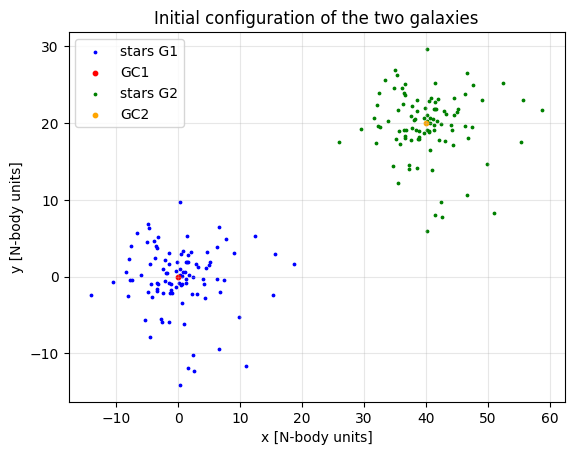

In [6]:
# visualize the two galaxies

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib widget

fig = plt.figure()
plt.scatter(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], label='stars G1', s=3, color='blue')
plt.scatter(Galaxy1.pos[0,0], Galaxy1.pos[0,1], label='GC1', s=10, color='red')
plt.scatter(Galaxy2.pos[1:,0], Galaxy2.pos[1:,1], label='stars G2', s=3, color='green')
plt.scatter(Galaxy2.pos[0,0], Galaxy2.pos[0,1], label='GC2', s=10, color='orange')
plt.xlabel('x [N-body units]')
plt.ylabel('y [N-body units]')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.title('Initial configuration of the two galaxies')

plt.show()

# <span style="color:springgreen">3 - Stability of the disc representation</span>

We ran a simulation of the isolated galaxy to verify the stability of both the rotation curve and the disc surface density over a certain characteristic timescale. This characteristic timescale was estimated as the time required for the disc tracers to complete an orbit around the Galaxy. We used the average radius of the galaxy to calculate the period according to the $3^{rd}$ Kepler law. To visualize the rotation curve and the surface density profile of the galaxy, we converted the position of the galaxy, taking the galactic center as the origin of the system, to cylindrical coordinates.

## Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius. To estimate the azimuthal velocity for each particle we transformed cartesian coordinates to cylindrical ones: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt{x^2+y^2} \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi) .
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius.

We developed some function to help us to obtain the plots:
* `rotation_curve_rescaled`: takes as input the class and the particle we defined as the galactic center and outputs the cylindrical radius and the azimuthal velocity (rescaled to the galactic center);
* `surface_density`: computes the numerical surface density taking as input the cylindrical radius;
* `integration_leapfrog`: integrates the galaxy over the time of the simulation using the integrator leapfrog; moreover it computes the cyclindrical radius and the azimuthal velocity using `rotation_curve_rescaled`.

---





In [7]:
from typing import Optional, Tuple, Callable, Union

def rotation_curve_rescaled(galaxy: Particles, GC: float):
    
    # rescale the position and velocity of the particles
    # GC is the particle assumed as the center of the galaxy
    X = galaxy.pos[:,:] - galaxy.pos[GC,:]
    V = galaxy.vel[:,:] - galaxy.vel[GC,:]

    # compute the cylindrical radius and azimuthal angle
    Rcyl = np.sqrt(X[:,0]**2. + X[:,1]**2.)                # cylindrical radius
    phi = np.arctan2(X[:,1], X[:,0])                       # azimuthal angle
    Z = X[:,2]                                             # z-coordinate

    # compute velocities    
    vel_phi = V[:,1] * np.cos(phi) - V[:,0] * np.sin(phi)     # azimuthal velocity
    vel_r = np.cos(phi) * V[:,0] + np.sin(phi) * V[:,1]         # radial velocity
    vel_z = V[:,2]                                                      # vertical velocity

    return Rcyl, Z, vel_phi, vel_r, vel_z

def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

In [8]:
def integration_leapfrog(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float, GC: float):
    N = int((tsimulation - t) / h)  # number of time steps
    num_particles = len(galaxy.mass)  # number of particles in the galaxy
    path = np.empty((N, num_particles, 3))  # array to store the position of the galaxy
    velocity = np.empty((N, num_particles, 3))  # array to store the velocity of the galaxy
    time = np.empty(N)
    timestep = np.empty(N)
    
    R_cyl, _, V_phi, V_r, V_z = rotation_curve_rescaled(galaxy, GC)
    R_cyl = [R_cyl]
    V_phi = [V_phi]
    V_r = [V_r]
    V_z = [V_z]

    i = 0
    while t < tsimulation - h:
        updated_galaxy, _,  updated_acc, _, _ = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        path[i] = updated_galaxy.pos
        velocity[i] = updated_galaxy.vel
            
        R, z, Vphi, Vr, Vz = rotation_curve_rescaled(updated_galaxy, GC)

        timestep[i] = h
        t += h
        time[i] = t

        R_cyl.append(R)
        V_phi.append(Vphi) 
        V_r.append(Vr)
        V_z.append(Vz)

        i += 1

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)
    V_r = np.array(V_r)
    V_z = np.array(V_z)

    return path, velocity, time, R_cyl, V_phi, V_r, V_z

In [9]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

radius = np.sqrt(np.sum((Galaxy1.pos-Galaxy1.pos[0])**2., axis=1))       # radius array

central_mass = Galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))                  # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy (suggested by the professor)

print(f'Mean period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Galaxy1_test = Galaxy1.copy()

# integrate the system using the leapfrog method

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_time, Galaxy1_Rcyl, Galaxy1_Vphi, Galaxy1_Vr, Galaxy1_Vz = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght, GC=0)

print(Galaxy1_orbit.shape)
# (iterations, particles, positions)

Mean period of the galaxy (approximately): 98.32665772930324
(1000, 100, 3)


We can now plot the trajectories of each particle of the galaxy, highlighting the initial and the final positions. The integration time is the mean period of the particles. 

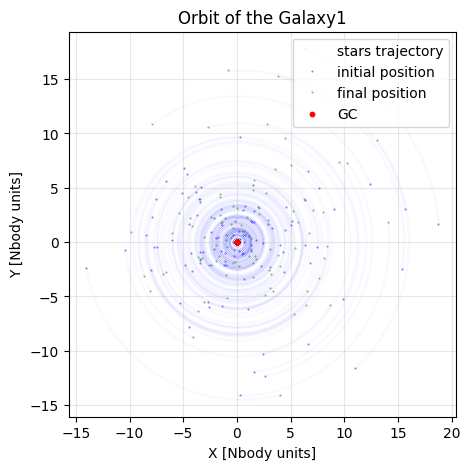

In [10]:
# plot the orbit of the galaxy

plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.05, color='b', label='stars trajectory', alpha=0.01)
plt.plot(Galaxy1_orbit[0,1:,0], Galaxy1_orbit[0,1:,1], 'o', markersize=0.5, c='b', label='initial position', alpha=0.5)
plt.plot(Galaxy1_orbit[-1,1:,0], Galaxy1_orbit[-1,1:,1], 'o', markersize=0.5, c='g', label='final position', alpha=0.5)
plt.scatter(Galaxy1_orbit[:,0,0], Galaxy1_orbit[:,0,1], s=10, color='r', label='GC', zorder=10)
plt.xlabel('X [Nbody units]')
plt.ylabel('Y [Nbody units]')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

### Rotation Curve and Density profile:


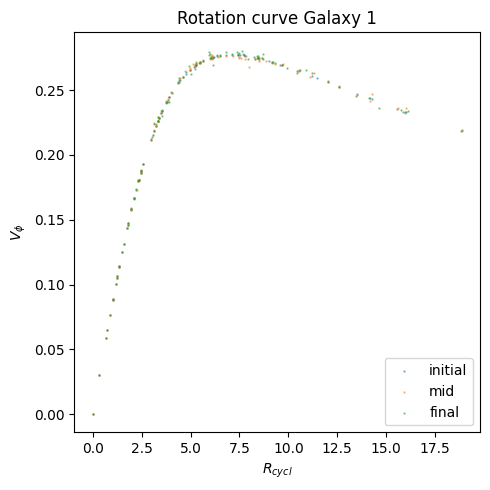

In [11]:
plt.figure(figsize=(5, 5))
n = Galaxy1_Rcyl.shape[0]
snapshots = np.arange(0, n, n//2)
title = ['initial', 'mid', 'final']
for i in range (len(snapshots)):
    plt.scatter(Galaxy1_Rcyl[snapshots[i],:], Galaxy1_Vphi[snapshots[i],:], s=0.5, label=title[i], alpha=0.5)
    
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{\phi}$')
plt.title('Rotation curve Galaxy 1')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  

In [12]:
# intial surface density
mid, H, area = surface_density(Galaxy1_Rcyl[0])

# final surface density
mid_end, H_end, area_end = surface_density(Galaxy1_Rcyl[-1])

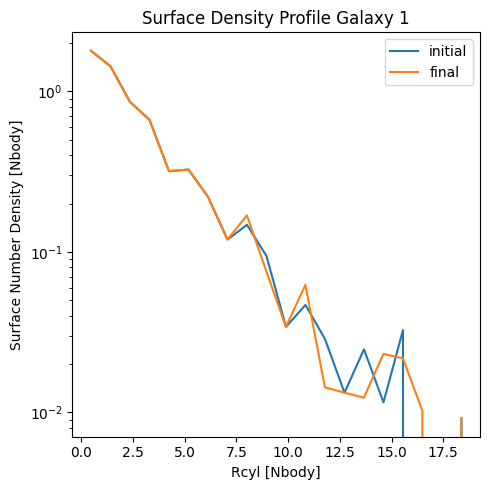

In [13]:
# plot the surface density of the initial and final galaxy
plt.figure(figsize=(5,5))
plt.plot(mid, H / area, label='initial')
plt.plot(mid_end, H_end / area_end, label='final')
plt.yscale('log')
plt.xlabel("Rcyl [Nbody]")  
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile Galaxy 1")
plt.legend()
plt.tight_layout()
plt.show()

Here we can see that both the rotation curve and the surface density profile remain stable over the selected timescale, equal to one period. This graphs are in line with theoretical expectations; therefore the disk can be considered stable.   \
Naturally, if we increase the number of stars the surface density profile of the galaxy would have a more linear decay even at larger radii; anyway we had to work  with $10^3$ particles because otherwise the kernel crushed. 

We can follow the same procedure for the other galaxy, obtaining the same results. 

---

# <span style="color:springgreen">4 - Galaxy encounter</span>

We now run a galaxy encounter to see how the disc geometry of the galaxies, their rotation curve and their surface density profile evolve with time. We use the two galaxies defined before (one of which was translated in both $\vec{v}_{com}$ and $\vec{x}_{com}$).

First of all, we generate a single Particles instance with both galaxies, so to account for interaction between the two galaxies.

In [14]:
# combine Galaxy1 and Galaxy2 into a single Particles instance
combined_pos = np.concatenate((Galaxy1.pos, Galaxy2.pos))
combined_vel = np.concatenate((Galaxy1.vel, Galaxy2.vel))
combined_mass = np.concatenate((Galaxy1.mass, Galaxy2.mass))

Combined_Galaxies = Particles(combined_pos, combined_vel, combined_mass)

div = int(num_particles) # first index of the second galaxy

We define another function for the integration `integration_leapfrog_encounter` to differentiate the rescaling for the two galaxies based on the ID of the particles. 

In [15]:
def integration_leapfrog_encounter(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):
    N = int((tsimulation - t) / h)  # number of time steps
    num_particles = len(galaxy.mass)  # number of particles in the galaxy
    path = np.empty((N, num_particles, 3))  # array to store the position of the galaxy
    velocity = np.empty((N, num_particles, 3))  # array to store the velocity of the galaxy
    time = np.empty(N)
    timestep = np.empty(N)
    
    R_cyl, _, V_phi, V_r, V_z = rotation_curve_rescaled(galaxy, GC=np.where(galaxy.ID < (len(galaxy.ID)//2), 0, len(galaxy.ID)//2))
    R_cyl = [R_cyl]
    V_phi = [V_phi]
    V_r = [V_r]
    V_z = [V_z]

    i = 0
    while t < tsimulation:
        updated_galaxy, _,  updated_acc, _, _ = integrator_leapfrog(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        path[i] = updated_galaxy.pos
        velocity[i] = updated_galaxy.vel
            
        R, z, Vphi, Vr, Vz = rotation_curve_rescaled(updated_galaxy, GC=np.where(updated_galaxy.ID < (len(updated_galaxy.ID)//2), 0, len(updated_galaxy.ID)//2))

        timestep[i] = h
        t += h
        time[i] = t

        R_cyl.append(R)
        V_phi.append(Vphi) 
        V_r.append(Vr)
        V_z.append(Vz)

        i += 1

    R_cyl = np.array(R_cyl)
    V_phi = np.array(V_phi)
    V_r = np.array(V_r)
    V_z = np.array(V_z)

    return path, velocity, time, R_cyl, V_phi, V_r, V_z

We then run the simulation for the encounter, using the function just defined. 

In [16]:
# set the parameters for the integration
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_test = Combined_Galaxies.copy()

Combined_Galaxies_orbit, Combined_Galaxies_stars_vel, Combined_Galaxies_time, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_Galaxies_Vr, Combined_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Combined_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

### Plot of the whole evolution
We make a plot showing the whole evolution of the galaxies, namely the trajectories of the trackers and of the galactic centers. We display even the initial and final positions of the galaxies. 

In [17]:
def plot_encounter_image(Galaxies: np.array, div: int):
    """
    :Galaxies: array containing the position of the galaxies and the GCs
    :div: index of the first and second Galactic center
    """

    plt.figure(figsize=(8,8))

    # stars trajectory
    plt.scatter(Galaxies[:,1:div,0], Galaxies[:,1:div,1], s=0.005, color='lightblue',  alpha=0.05)
    plt.scatter(Galaxies[:,(div+1):,0],  Galaxies[:,(div+1):,1],  s=0.005, color='lightgreen', alpha=0.05)

    # initial and final position of galaxy 1
    plt.plot(Galaxies[0,1:div,0],  Galaxies[0,1:div,1],  'o', markersize=2, c='cornflowerblue', label='initial position of Gal1', alpha=0.3)
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], '*', markersize=3, c='b', label='final position of Gal1',   alpha=0.3)

    # initial and final position of galaxy 2
    plt.plot(Galaxies[0,(div+1):,0],  Galaxies[0,(div+1):,1],  'o', markersize=2, c='limegreen', label='initial position of Gal2', alpha=0.3)
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], '*', markersize=3, c='g', label='final position of Gal2',   alpha=0.3)

    # initial and final position of GC1
    plt.plot(Galaxies[0,0,0],  Galaxies[0,0,1],  'o', markersize=4, color='r', label='GC 1', zorder=10)
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r',               zorder=10)

    # initial and final position of GC2
    plt.plot(Galaxies[0,div,0],  Galaxies[0,div,1],  'o', markersize=4, color='orange', label='GC 2', zorder=10)
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange',               zorder=10)

    # trajectory of GC1
    plt.scatter(Galaxies[:,0,0],    Galaxies[:,0,1],    s=0.05, color='r',      zorder=10, alpha=0.5)
    # trajectory of GC2
    plt.scatter(Galaxies[:,div,0], Galaxies[:,div,1], s=0.05, color='orange', zorder=10, alpha=0.5)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxies Encounter')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.5)
    plt.show()
    

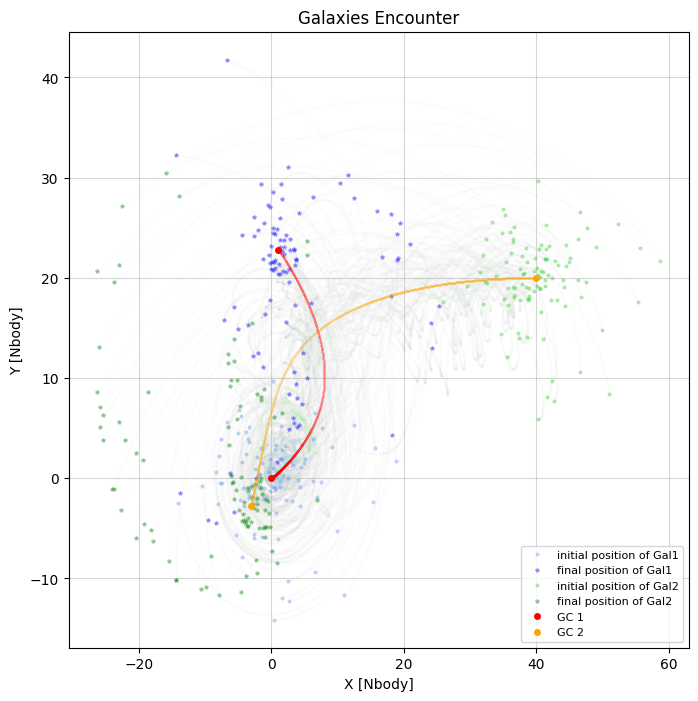

In [18]:
# Plot the encounter
plot_encounter_image(Combined_Galaxies_orbit, div)

### Final situation
We make a plot showing the final configuration of the galaxies after the encounter, the evolution of the rotation curve and the evolution of the surface density profile.  

In [19]:
# intial surface density G1
mid_in_1, H_in_1, area_in_1 = surface_density(Combined_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_end_1, H_end_1, area_end_1 = surface_density(Combined_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_in_2, H_in_2, area_in_2 = surface_density(Combined_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_end_2, H_end_2, area_end_2 = surface_density(Combined_Galaxies_Rcyl[-1,div:])

surface_density_G1 = ((mid_in_1, H_in_1, area_in_1),(mid_end_1, H_end_1, area_end_1))
surface_density_G2 = ((mid_in_2, H_in_2, area_in_2),(mid_end_2, H_end_2, area_end_2))

Combined_surface_densities = (surface_density_G1, surface_density_G2)


In [20]:
def encounter_result(Galaxies: np.array, div: int, Galaxies_Rcyl: np.array, Galaxies_Vphi: np.array, Surface_Densities: Tuple[Tuple[Tuple[np.array, np.array, np.array], 
                                                                                                                            Tuple[np.array, np.array, np.array]], 
                                                                                                                            Tuple[Tuple[np.array, np.array, np.array], 
                                                                                                                            Tuple[np.array, np.array, np.array]]]):
    """
    Galaxy: array containing the position of the galaxies and the GCs
    div: index of the first and second Galactic center
    Galaxies_Rcyl: array containing the cylindrical radius of the galaxies
    Galaxies_Vphi: array containing the azimuthal velocity of the galaxies
    Surface_Densities: tuple containing the surface density of the galaxies
    """
    
    plt.subplots(3,3,figsize=(12,12))

    plt.subplot(3, 3, 1)
    # final position of galaxy 1
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], 'o', markersize=1, c='b', label='final position of Gal1',   alpha=0.5)
    # position of GC1
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r', label='GC 1', zorder=10)
    # final position of galaxy 2
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], 'o', markersize=1, c='g', label='final position of Gal2',   alpha=0.5)
    # position of GC2
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange', label='GC 2', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Final position of the Galaxies')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 2)
    # final position of galaxy 1
    plt.plot(Galaxies[-1,1:div,0], Galaxies[-1,1:div,1], 'o', markersize=1, c='b', label='final position of Gal1',   alpha=0.5)
    # position of GC1
    plt.plot(Galaxies[-1,0,0], Galaxies[-1,0,1], 'o', markersize=4, color='r', label='GC 1', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxy 1')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 3)
    # final position of galaxy 2   
    plt.plot(Galaxies[-1,(div+1):,0], Galaxies[-1,(div+1):,1], 'o', markersize=1, c='g', label='final position of Gal2',   alpha=0.5)
    # position of GC2
    plt.plot(Galaxies[-1,div,0], Galaxies[-1,div,1], 'o', markersize=4, color='orange', label='GC 2', zorder=10)

    plt.xlabel('X [Nbody]')
    plt.ylabel('Y [Nbody]')
    plt.title('Galaxy 2')
    plt.legend(loc='lower right', fontsize=8)

    plt.subplot(3, 3, 5)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vphi[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vphi[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve Galaxy 1')

    plt.subplot(3, 3, 6)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vphi[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vphi[0,(div+1):], s=0.5, color='darkorange', label='initial', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve Galaxy 2')

    plt.subplot(3, 3, 4)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vphi[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vphi[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vphi[0,(div+1):], s=0.5, color='darkorange', label='initial G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vphi[0,1:div], s=0.5, color='b', label='initial G1', alpha=0.5)
    plt.legend(loc='best', fontsize=8)
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{\phi}$')
    plt.title('Rotation curve (G1 and G2)')

    mid_in_1, H_in_1, area_in_1 = Surface_Densities[0][0]
    mid_end_1, H_end_1, area_end_1 = Surface_Densities[0][1]
    mid_in_2, H_in_2, area_in_2 = Surface_Densities[1][0]
    mid_end_2, H_end_2, area_end_2 = Surface_Densities[1][1]

    plt.subplot(3, 3, 7)
    plt.plot(mid_in_1, H_in_1 / area_in_1, label='initial G1 and G2', c='b')
    plt.plot(mid_end_1, H_end_1 / area_end_1, label='final G1', c='r')
    plt.plot(mid_end_2, H_end_2 / area_end_2, label='final G2', c='g')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile (G1 and G2)")

    plt.subplot(3, 3, 8)
    plt.plot(mid_in_1, H_in_1 / area_in_1, label='initial', c='b')
    plt.plot(mid_end_1, H_end_1 / area_end_1, label='final', c='r')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile Galaxy 1")

    plt.subplot(3, 3, 9)
    plt.plot(mid_in_2, H_in_2 / area_in_2, label='initial', c='b')
    plt.plot(mid_end_2, H_end_2 / area_end_2, label='final', c='g')
    plt.yscale('log')
    plt.xlabel("Rcyl [Nbody]")  
    plt.ylabel("Surface Number Density [Nbody]")
    plt.legend(loc='best', fontsize=8)
    plt.title("Surface Density Profile Galaxy 2")


    plt.tight_layout()
    plt.show()

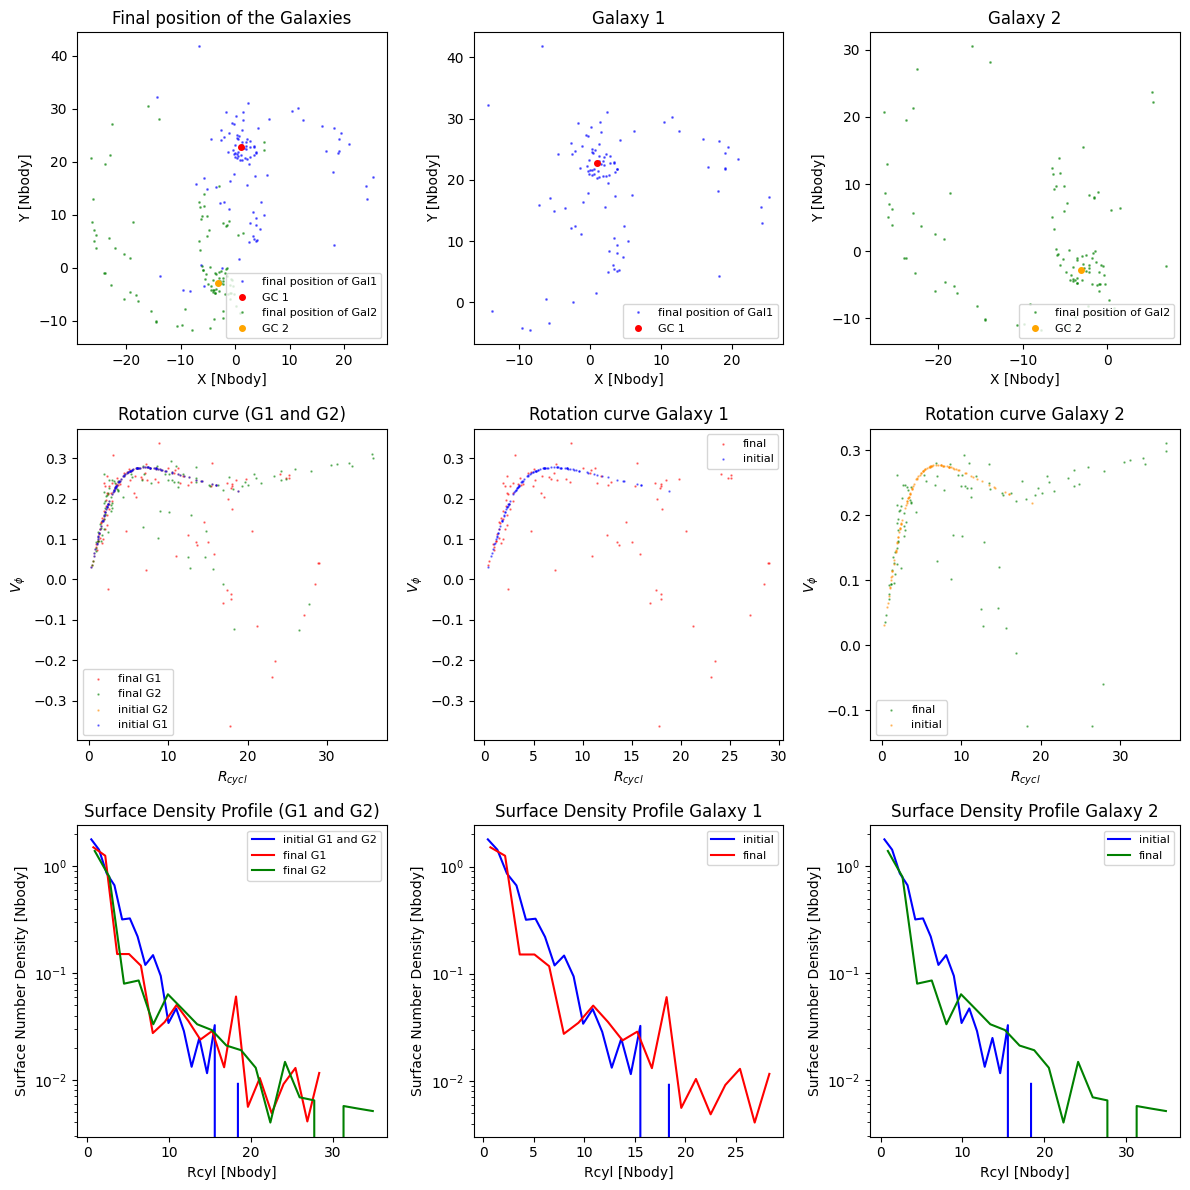

In [21]:
encounter_result(Combined_Galaxies_orbit, div, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_surface_densities)

Starting from the rotation curves and the surface density profiles we can see that we lose the stability of the galaxies. Both of them are more extended for what concerns $R_{cyl}$, due to the fact that radius of the galaxies after the encounter is bigger than the one of the initial configuration.  \
As we can see from the surface density profiles of the two galaxies, there is a decrease of $\Sigma$ at lower radii and an increase at larger radii. This is because the particles tend to migrate toward outer radii due to the attraction of the other galaxy.  \
Furthermore looking at the rotation curve we can notice that the final plot is very scattered, and some particles will start to counterrotate as well ($V_{\phi} < 0$). The detouchment from the initial situation is more pronounced at larger radii, as expected. 

Talking about the disc geometry we can visually inspect the production of structures after the interaction between the two galaxies. In particular we can see the formation of two tidal tails as a result of galactic tide forces (stellar currents). 



### Evolution of radial and vertical velocity

In the following plot we can see the evolution of the radial and vertical components of the velocity, knowing that at the beginning they are zero by construction. 

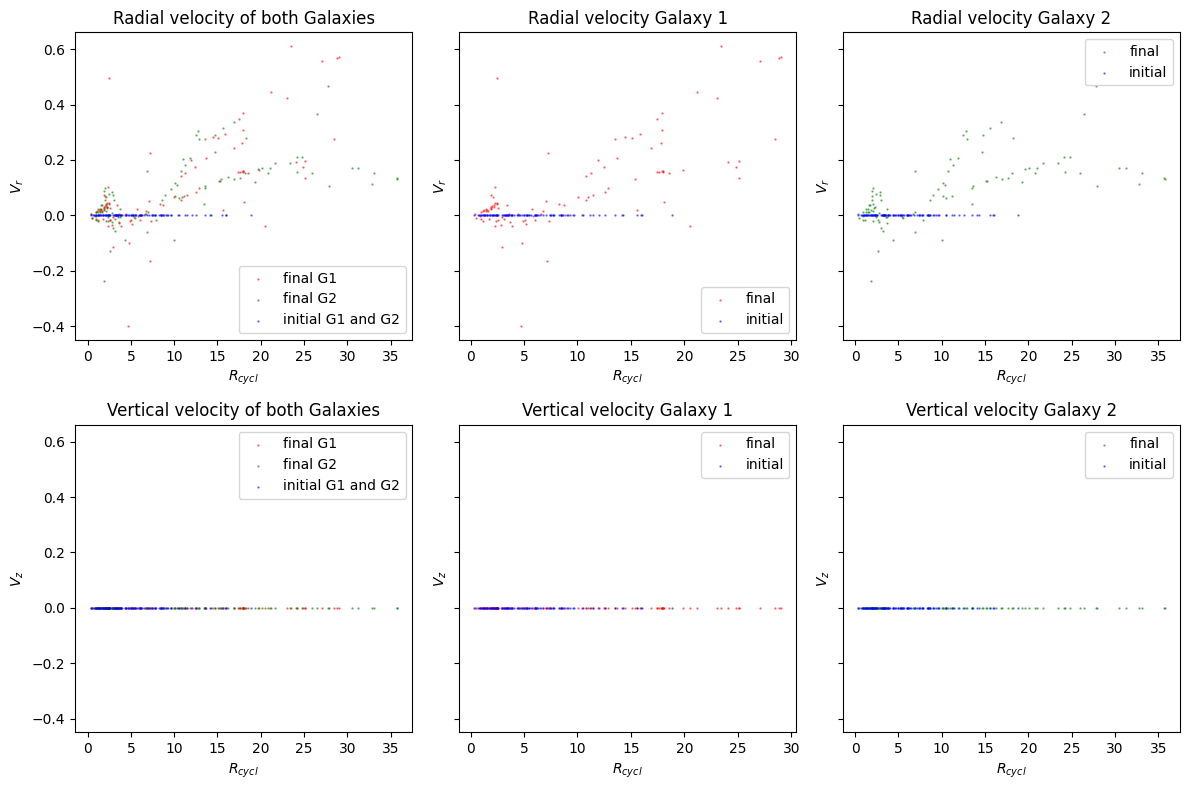

In [22]:
def Radial_Vertical_velocity(Galaxies_Rcyl: np.array, Galaxies_Vr: np.array, Galaxies_Vz: np.array, div: int):
    """
    Galaxies_Rcyl: array containing the cylindrical radius of the galaxies
    Galaxy1_Vr: array containing the azimuthal velocity of the galaxies
    Galaxy1_Vz: array containing the vertical velocity of the galaxies
    div: index of the first and second Galactic center
    """
    plt.subplots(2,3,figsize=(12,8), sharey=True)

    plt.subplot(2, 3, 2)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vr[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vr[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity Galaxy 1')

    plt.subplot(2, 3, 3)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vr[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vr[0,(div+1):], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity Galaxy 2')

    plt.subplot(2, 3, 1)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vr[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vr[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vr[0,1:div], s=0.5, color='b', label='initial G1 and G2', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{r}$')
    plt.title('Radial velocity of both Galaxies')

    plt.subplot(2, 3, 5)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vz[-1,1:div], s=0.5, color='r', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vz[0,1:div], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Vertical velocity Galaxy 1')

    plt.subplot(2, 3, 6)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vz[-1,(div+1):], s=0.5, color='g', label='final', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,(div+1):], Galaxies_Vz[0,(div+1):], s=0.5, color='b', label='initial', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Vertical velocity Galaxy 2')

    plt.subplot(2, 3, 4)
    plt.scatter(Galaxies_Rcyl[-1,1:div], Galaxies_Vz[-1,1:div], s=0.5, color='r', label='final G1', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[-1,(div+1):], Galaxies_Vz[-1,(div+1):], s=0.5, color='g', label='final G2', alpha=0.5)
    plt.scatter(Galaxies_Rcyl[0,1:div], Galaxies_Vz[0,1:div], s=0.5, color='b', label='initial G1 and G2', alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel('$R_{cycl}$')
    plt.ylabel('$V_{z}$')
    plt.title('Vertical velocity of both Galaxies')

    plt.tight_layout()
    plt.show()

Radial_Vertical_velocity(Combined_Galaxies_Rcyl, Combined_Galaxies_Vr, Combined_Galaxies_Vz, div)

From the simulation we can notice that after the encounter particles will no longer follow a stable circular orbit. In particular:

- The radial velocity starts from $v_r = 0$ for both galaxies and ends with a very scattered plot, in which we have $R_{cyl} \lesssim 5 \implies v_r \lesssim 0$, and  $R_{cyl} \gtrsim 5 \implies v_r \gtrsim 0$, with the exception of the very central region, where $v_r \gtrsim 0$. This was expected because tidal interactions act mostly on the outer part of the galaxy, where the potential well is weaker: after a certain radius stars of both galaxies are stripped out from the potential well of the central mass; instead, in the central regions particles tend to migrate inward, toward the centre of the galaxy (see `Simple_encounter.gif` in the folder `images/gif`). 
- On the other hand the vertical velocity starts from $v_z = 0$ and ends at $v_z = 0$. This is straightforward because in this simulation we considered a planar encounter confined in the $(x-y)$ plane, and from the conservation of the angular momentum all the motion has to be confined in the same plane. The only difference between the initial and the final situation is the smearing of the velocity at larger radii. This is can be intuitively understood with the considerations done previously: since the outer stars are stripper out, at the end of the simulations they will be located at larger radii, even if keeping a null vertical velocity.

We will address the problem of the change of inclination of the two galaxies in the following.

# <span style="color:springgreen">5 - Counter-rotating galaxies</span>

We try to run a simulation using different galactic parameters. In particular we change the initial conditions of the Galaxy1 by multiplying all the velocities of the first galaxy by -1. In this way the galaxies are counter-rotating, meaning that one rotates in a clockwise direction while the other one in a counter-clockwise. \
We then proceed with an approach analogous to the previous one. 

In [23]:
# invert the velocity of the first galaxy
Combined_Galaxies_counter = Combined_Galaxies.copy()
Combined_Galaxies_counter.vel[1:div] = -Combined_Galaxies_counter.vel[1:div]

In [24]:
# set the parameters for the integration
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Counter_Galaxies_test = Combined_Galaxies_counter.copy()

Counter_Galaxies_orbit, Counter_Galaxies_stars_vel, Counter_Galaxies_time, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi, Counter_Galaxies_Vr, Counter_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Counter_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

As we have done before, me make three plots: one displaying the whole evolution of the two galaxies, along with their initial and final position, the second one where we show the evolution of the rotation curve and of the surface density profile, and the last one in which we can see the evolution of the vertical and radial components of the velocity. 

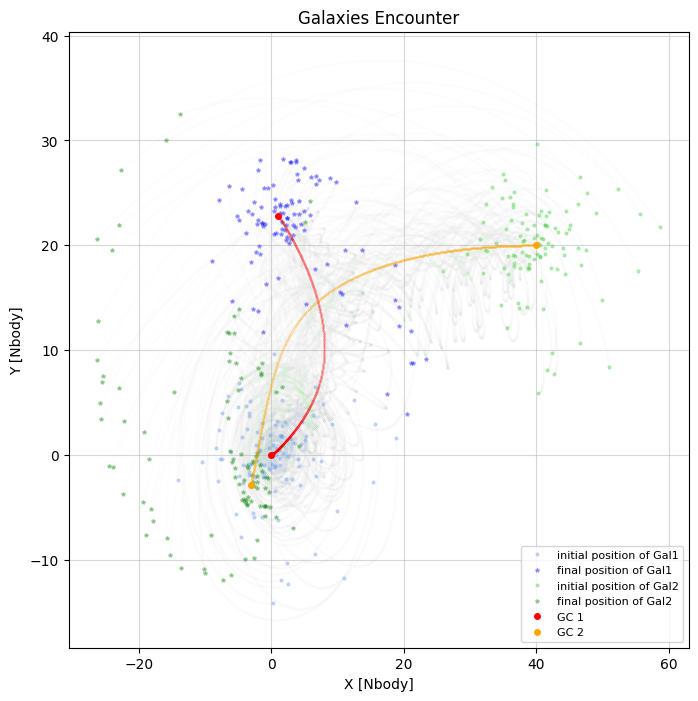

In [25]:
# Plot the encounter
plot_encounter_image(Counter_Galaxies_orbit, div)

In [26]:
# intial surface density G1
mid_c_in_1, H_c_in_1, area_c_in_1 = surface_density(Counter_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_c_end_1, H_c_end_1, area_c_end_1 = surface_density(Counter_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_c_in_2, H_c_in_2, area_c_in_2 = surface_density(Counter_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_c_end_2, H_c_end_2, area_c_end_2 = surface_density(Counter_Galaxies_Rcyl[-1,div:])

surface_density_G1_c = ((mid_c_in_1, H_c_in_1, area_c_in_1),(mid_c_end_1, H_c_end_1, area_c_end_1))
surface_density_G2_c = ((mid_c_in_2, H_c_in_2, area_c_in_2),(mid_c_end_2, H_c_end_2, area_c_end_2))
Combined_surface_densities_counter = (surface_density_G1_c, surface_density_G2_c)

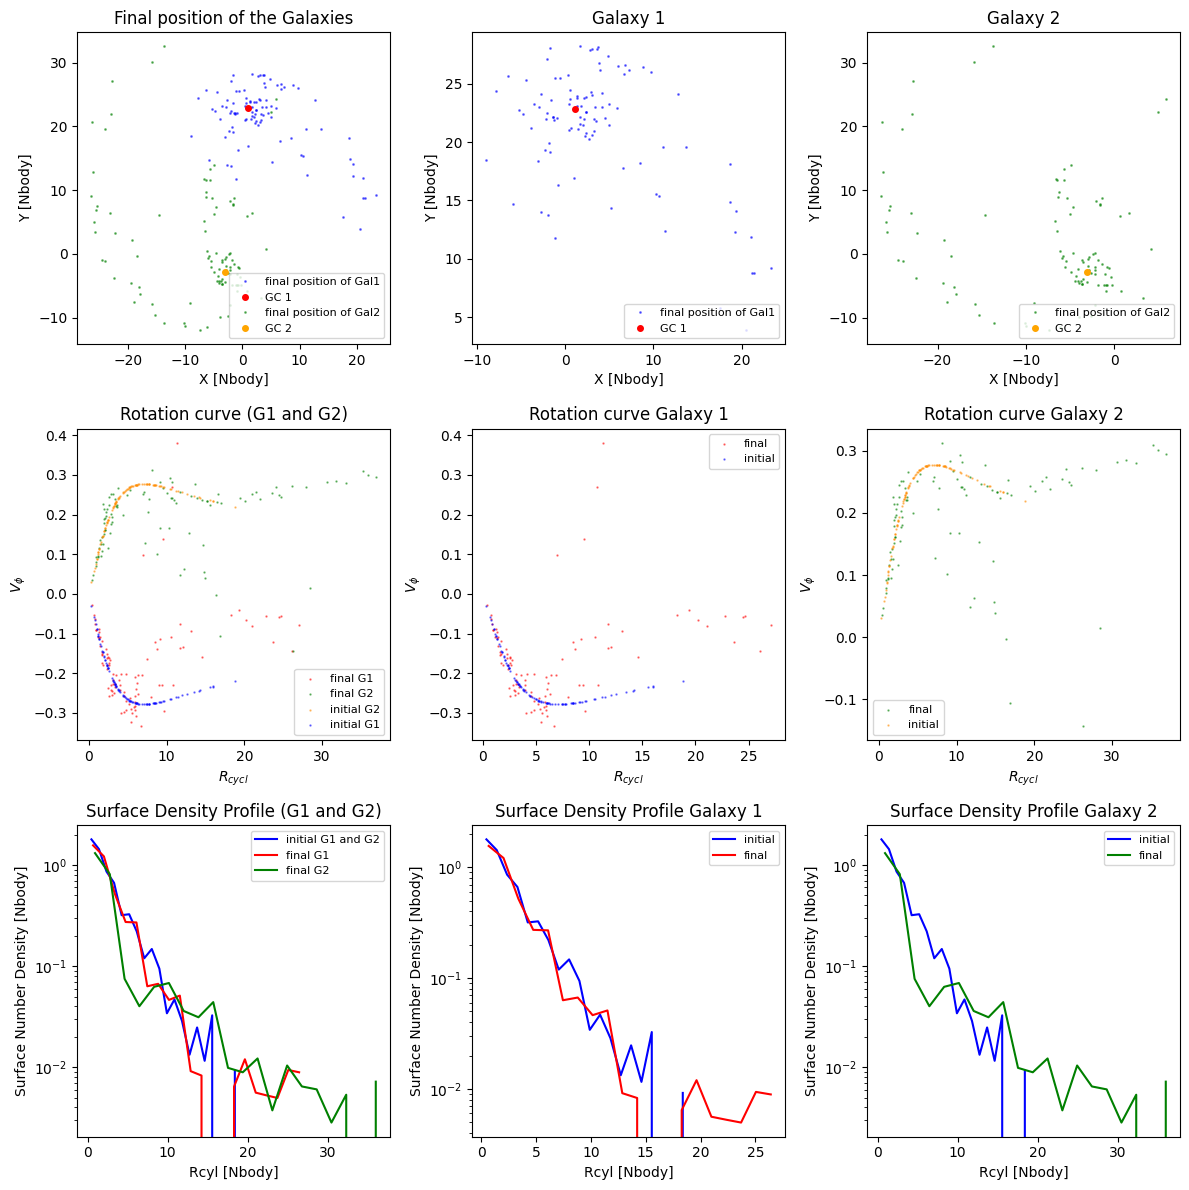

In [27]:
encounter_result(Counter_Galaxies_orbit, div, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi, Combined_surface_densities_counter)

From these plots, we can see that the results resemble the one obtained from the previous cases, but with some differences. \
In particular, $\Sigma$ shows approximately the same behaviour as before for the Galaxy2, while the detouchment of the Galaxy2 from the initial configuration is less accentuated, mostly regarding the inner part. This is clear also from the picture of the final configuration: Galaxy1 is more "concentrated". \
From the velocity curve we can also notice that some particles belonging to one galaxy have been captured by the other galaxy. This is more obvious in this situation because the two initial rotation curves are located in two different quadrants: one is entirely whith $V_\phi > 0$ while the other is characterized by $V_\phi < 0$.

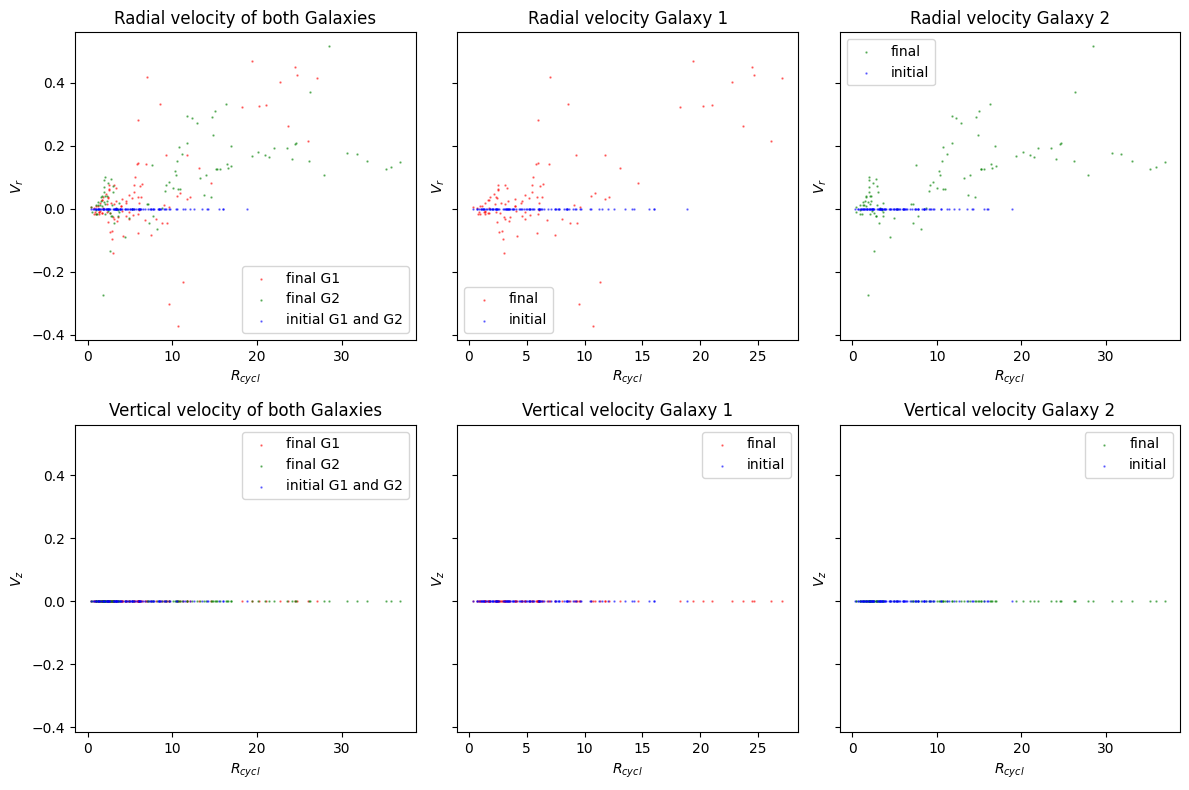

In [28]:
# plot the Radial Velocity and Vertical Velocity

Radial_Vertical_velocity(Counter_Galaxies_Rcyl, Counter_Galaxies_Vr, Counter_Galaxies_Vz, div)

In this case for the Galaxy2 the situation is very similar to the previous case; on the other hand, for Galaxy1 the graph for $V_r$ has a less defined behavior, but anyway it shows a predominant radial outward motion ($V_r> 0$). \
The $V_z$ case is almost identical to the other configuration.

---

# <span style="color:springgreen">6 - Encounter with different disc inclinations</span>

Let us call $(x,y,z)$ the starting reference frame, and $(x',y',z')$ the one in which we want to put ourselves. The second one is obtained through a rotation about the y-axis by an arbitrary angle $\alpha$. In reality we should account for two angles: the angle that the $z$ axis forms with the disk plane ($i$) and the angle by which the plane is rotated in the $(x-y)$ plane ($\phi$). Anyway, to make things simpler, we can just use the cylindrical symmetry of our problem and consider $\phi = 0$. \
Furthermore, in order to go back to astrophysical cases, in which we usually use the inclination $i$, we can just use the fact that $i$ is simply the complementary angle of $\alpha$: $i = 90 \degree - \alpha$. 
Then, we have 
$$
\begin{cases}
    x' = x cos (\alpha) = x sin (i) \\
    y' = y \\
    z' = x sin (\alpha) = x cos (i) 

\end{cases}
$$
Putting this in matricial form
$$
\begin{pmatrix}

     \cos(\alpha) & 0 & -\sin(\alpha) \\
    1 & 0 & 0 \\
     \sin(\alpha) &0 & \cos(\alpha)
\end{pmatrix}
$$
So that, being R this matrix, $\vec{r}' = R \cdot \vec{r}$. \
We can now re-define our dataframe so to account for this rotation.

In [29]:
# first, we define a function for the rotation by an angle alpha around the y axis

def rotation_y(alpha: float, x: float, y: float, z: float) -> Tuple[float, float, float]:
    """
    Rotate the point (x, y, z) by an angle alpha around the y axis
    """
    R = np.array([[np.cos(alpha), 0, np.sin(alpha)], [0, 1, 0], [-np.sin(alpha), 0, np.cos(alpha)]])
    point = np.array([x, y, z])
    new_point = np.dot(R, point)

    """
    Same as
    x_new = x * np.cos(alpha) + z * np.sin(alpha)
    y_new = y
    z_new = -x * np.sin(alpha) + z * np.cos(alpha)
    """

    return new_point[0], new_point[1], new_point[2]




In [30]:
Galaxy1_inclined = Galaxy1.copy()
Galaxy2_inclined = Galaxy2.copy()

# rotate the first galaxy by an angle of 45 degrees around the y axis
alpha = np.pi/4
for i in range(len(Galaxy1_inclined.pos)):
    Galaxy1_inclined.pos[i] = rotation_y(alpha, Galaxy1_inclined.pos[i][0], Galaxy1_inclined.pos[i][1], Galaxy1_inclined.pos[i][2])
    Galaxy1_inclined.vel[i] = rotation_y(alpha, Galaxy1_inclined.vel[i][0], Galaxy1_inclined.vel[i][1], Galaxy1_inclined.vel[i][2])


#Inclined_Galaxies = Combined_Galaxies.copy()

In [31]:
Galaxy1_inclined_test = Galaxy1_inclined.copy()
Galaxy2_inclined_test = Galaxy2_inclined.copy()

# Combine Galaxy1_inclined and Galaxy2_inclined into a single Particles class

combined_pos = np.concatenate((Galaxy1_inclined.pos, Galaxy2_inclined.pos))
combined_vel = np.concatenate((Galaxy1_inclined.vel, Galaxy2_inclined.vel))
combined_mass = np.concatenate((Galaxy1_inclined.mass, Galaxy2_inclined.mass))

Combined_Galaxies_inclined = Particles(combined_pos, combined_vel, combined_mass)

#evolve the combined galaxy with the leapfrog integrator

# reinitialize all the variables
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
tsimulation = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_inclined_test = Combined_Galaxies_inclined.copy()

Combined_Galaxies_inclined_orbit, Combined_Galaxies_inclined_stars_vel, Combined_Galaxies_inclined_time, Combined_Galaxies_inclined_Rcyl, Combined_Galaxies_inclined_Vphi, Combined_Galaxies_inclined_Vr, Combined_Galaxies_inclined_Vz = integration_leapfrog_encounter(galaxy=Combined_Galaxies_inclined_test, h=h,
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)



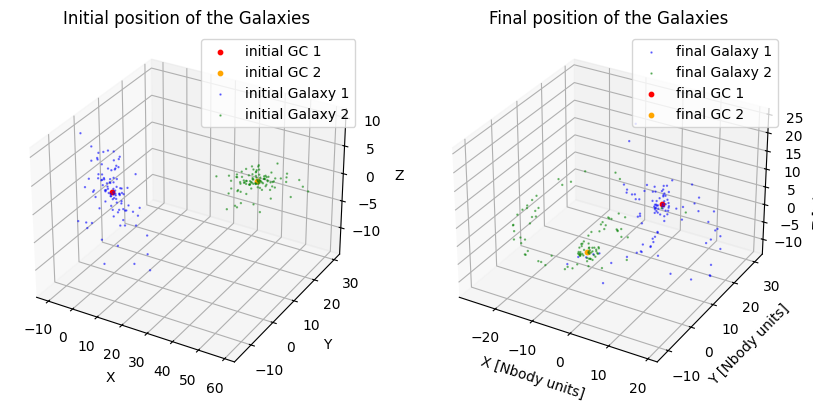

In [32]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(Combined_Galaxies_inclined_orbit[0,0,0], Combined_Galaxies_inclined_orbit[0,0,1], Combined_Galaxies_inclined_orbit[0,0,2], s=10, c='r', label='initial GC 1', zorder=10)
ax1.scatter(Combined_Galaxies_inclined_orbit[0,div,0], Combined_Galaxies_inclined_orbit[0,div,1], Combined_Galaxies_inclined_orbit[0,div,2], s=10, c='orange', label='initial GC 2', zorder=10)
ax1.scatter(Combined_Galaxies_inclined_orbit[0,1:div,0], Combined_Galaxies_inclined_orbit[0,1:div,1], Combined_Galaxies_inclined_orbit[0,1:div,2], s=0.5, c='b', label='initial Galaxy 1', alpha=0.5)
ax1.scatter(Combined_Galaxies_inclined_orbit[0,div+1:,0], Combined_Galaxies_inclined_orbit[0,div+1:,1], Combined_Galaxies_inclined_orbit[0,div+1:,2], s=0.5, c='g', label='initial Galaxy 2', alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Initial position of the Galaxies')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(Combined_Galaxies_inclined_orbit[-1,1:div,0], Combined_Galaxies_inclined_orbit[-1,1:div,1], Combined_Galaxies_inclined_orbit[-1,1:div,2], s=0.5, c='b', label='final Galaxy 1', alpha=0.5)
ax2.scatter(Combined_Galaxies_inclined_orbit[-1,div+1:,0], Combined_Galaxies_inclined_orbit[-1,div+1:,1], Combined_Galaxies_inclined_orbit[-1,div+1:,2], s=0.5, c='g', label='final Galaxy 2', alpha=0.5)
ax2.scatter(Combined_Galaxies_inclined_orbit[-1,0,0], Combined_Galaxies_inclined_orbit[-1,0,1], Combined_Galaxies_inclined_orbit[-1,0,2], s=10, c='r', label='final GC 1', zorder=-10)
ax2.scatter(Combined_Galaxies_inclined_orbit[-1,div,0], Combined_Galaxies_inclined_orbit[-1,div,1], Combined_Galaxies_inclined_orbit[-1,div,2], s=10, c='orange', label='final GC 2', zorder=-10)
ax2.set_xlabel('X [Nbody units]')
ax2.set_ylabel('Y [Nbody units]')
ax2.set_zlabel('Z [Nbody units]')
ax2.set_title('Final position of the Galaxies')
ax2.legend(loc='upper right')

plt.show()

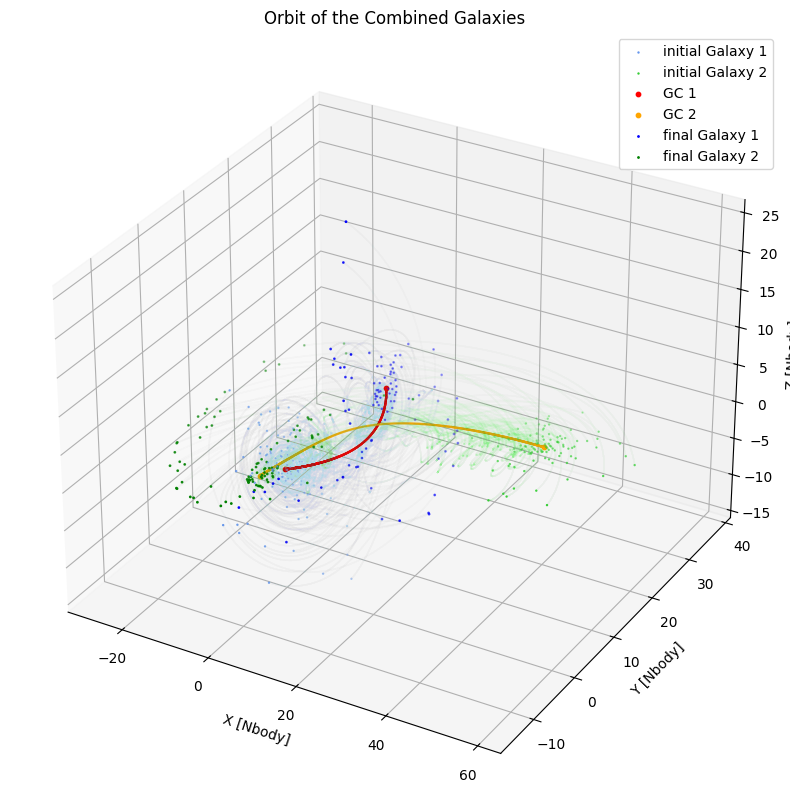

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# trajectories
ax.scatter(Combined_Galaxies_inclined_orbit[:,1:div,0], Combined_Galaxies_inclined_orbit[:,1:div,1], Combined_Galaxies_inclined_orbit[:,1:div,2], s=0.005, c='lightblue', alpha=0.05)
ax.scatter(Combined_Galaxies_inclined_orbit[:,div+1:,0], Combined_Galaxies_inclined_orbit[:,div+1:,1], Combined_Galaxies_inclined_orbit[:,div+1:,2], s=0.005, c='lightgreen', alpha=0.05)
ax.scatter(Combined_Galaxies_inclined_orbit[:,0,0], Combined_Galaxies_inclined_orbit[:,0,1], Combined_Galaxies_inclined_orbit[:,0,2], s=0.5, c='r', zorder=10)
ax.scatter(Combined_Galaxies_inclined_orbit[:,div,0], Combined_Galaxies_inclined_orbit[:,div,1], Combined_Galaxies_inclined_orbit[:,div,2], s=0.5, c='orange', zorder=10)

# initial position
ax.scatter(Combined_Galaxies_inclined_orbit[0,1:div,0], Combined_Galaxies_inclined_orbit[0,1:div,1], Combined_Galaxies_inclined_orbit[0,1:div,2], s=0.5, c='cornflowerblue', label='initial Galaxy 1')
ax.scatter(Combined_Galaxies_inclined_orbit[0,div+1:,0], Combined_Galaxies_inclined_orbit[0,div+1:,1], Combined_Galaxies_inclined_orbit[0,div+1:,2], s=0.5, c='limegreen', label='initial Galaxy 2')
ax.scatter(Combined_Galaxies_inclined_orbit[0,0,0], Combined_Galaxies_inclined_orbit[0,0,1], Combined_Galaxies_inclined_orbit[0,0,2], s=10, c='r', label='GC 1', zorder=10)
ax.scatter(Combined_Galaxies_inclined_orbit[0,div,0], Combined_Galaxies_inclined_orbit[0,div,1], Combined_Galaxies_inclined_orbit[0,div,2], s=10, c='orange', label='GC 2', zorder=10)

# final position
ax.scatter(Combined_Galaxies_inclined_orbit[-1,1:div,0], Combined_Galaxies_inclined_orbit[-1,1:div,1], Combined_Galaxies_inclined_orbit[-1,1:div,2], s=1, c='b', label='final Galaxy 1')
ax.scatter(Combined_Galaxies_inclined_orbit[-1,div+1:,0], Combined_Galaxies_inclined_orbit[-1,div+1:,1], Combined_Galaxies_inclined_orbit[-1,div+1:,2], s=1, c='g', label='final Galaxy 2')
ax.scatter(Combined_Galaxies_inclined_orbit[-1,0,0], Combined_Galaxies_inclined_orbit[-1,0,1], Combined_Galaxies_inclined_orbit[-1,0,2], s=10, c='r', zorder=10)
ax.scatter(Combined_Galaxies_inclined_orbit[-1,div,0], Combined_Galaxies_inclined_orbit[-1,div,1], Combined_Galaxies_inclined_orbit[-1,div,2], s=10, c='orange', zorder=10)

ax.set_xlabel('X [Nbody]')
ax.set_ylabel('Y [Nbody]')
ax.set_zlabel('Z [Nbody]')
ax.set_title('Orbit of the Combined Galaxies')
ax.legend(loc='upper right')

plt.show()


<div class='alert alert-block alert-warning'>
inserire conclusioni galassie inclinate + volendo grafico vz per vedere che è diverso da zero per piccole masse + strutture
</div>

In [34]:
# intial surface density G1
mid_in_in_1, H_in_in_1, area_in_in_1 = surface_density(Combined_Galaxies_inclined_Rcyl[0,:div])

# final surface density G1
mid_in_end_1, H_in_end_1, area_in_end_1 = surface_density(Combined_Galaxies_inclined_Rcyl[-1,:div])

# intial surface density G2 
mid_in_in_2, H_in_in_2, area_in_in_2 = surface_density(Combined_Galaxies_inclined_Rcyl[0,div:])

# final surface density G2
mid_in_end_2, H_in_end_2, area_in_end_2 = surface_density(Combined_Galaxies_inclined_Rcyl[-1,div:])

surface_density_G1_in = ((mid_in_in_1, H_in_in_1, area_in_in_1),(mid_in_end_1, H_in_end_1, area_in_end_1))
surface_density_G2_in = ((mid_in_in_2, H_in_in_2, area_in_in_2),(mid_in_end_2, H_in_end_2, area_in_end_2))
Combined_surface_densities_inclined = (surface_density_G1_in, surface_density_G2_in)

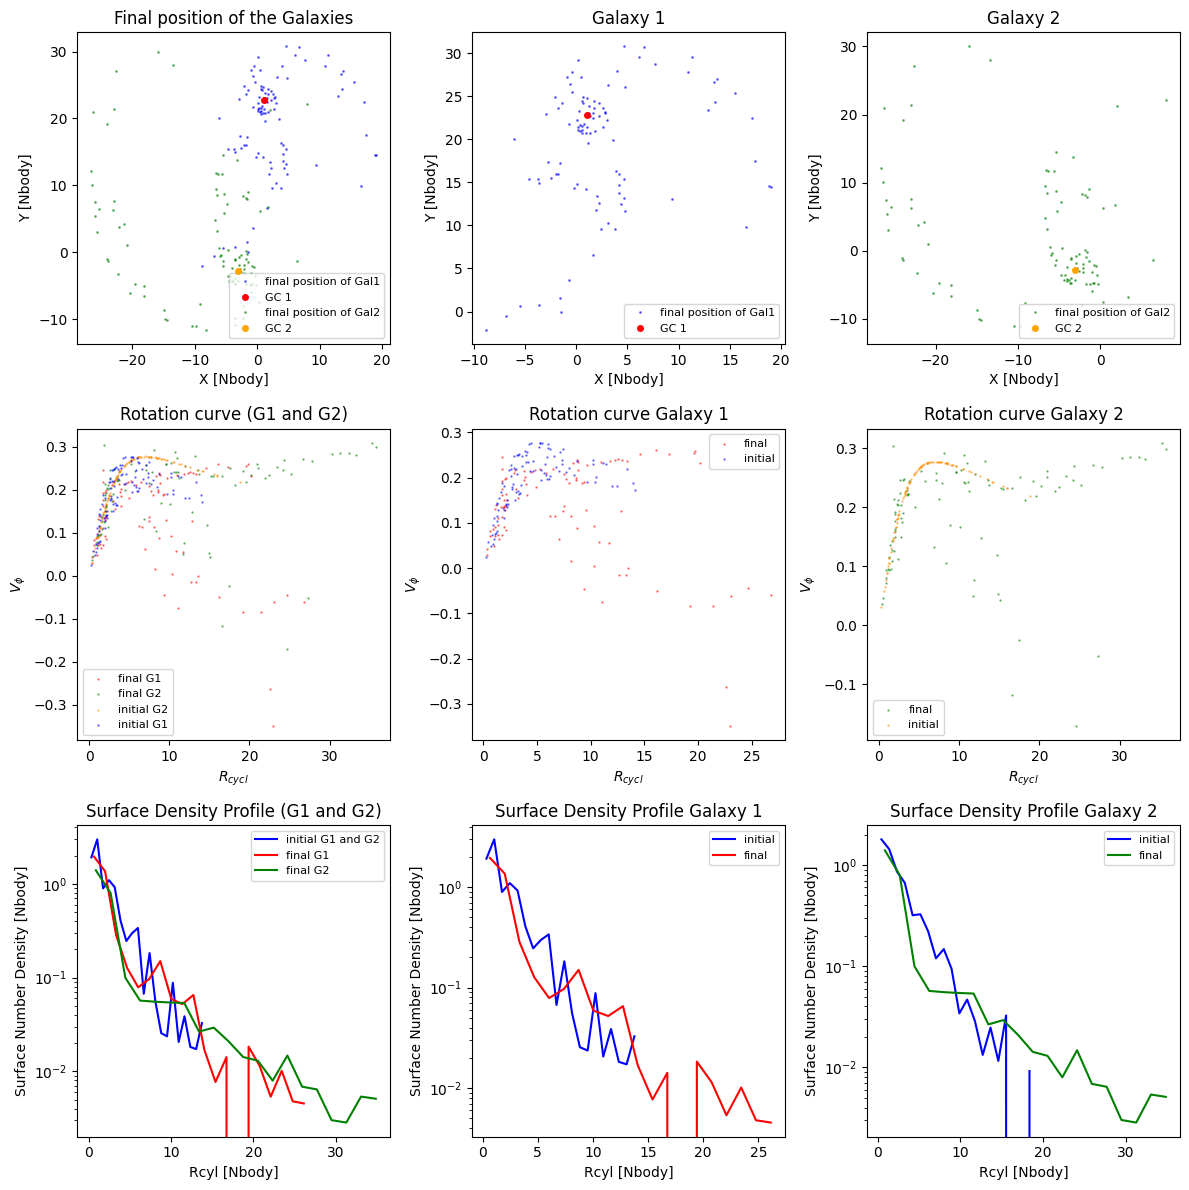

In [35]:
encounter_result(Combined_Galaxies_inclined_orbit, div, Combined_Galaxies_inclined_Rcyl, Combined_Galaxies_inclined_Vphi, Combined_surface_densities_inclined)

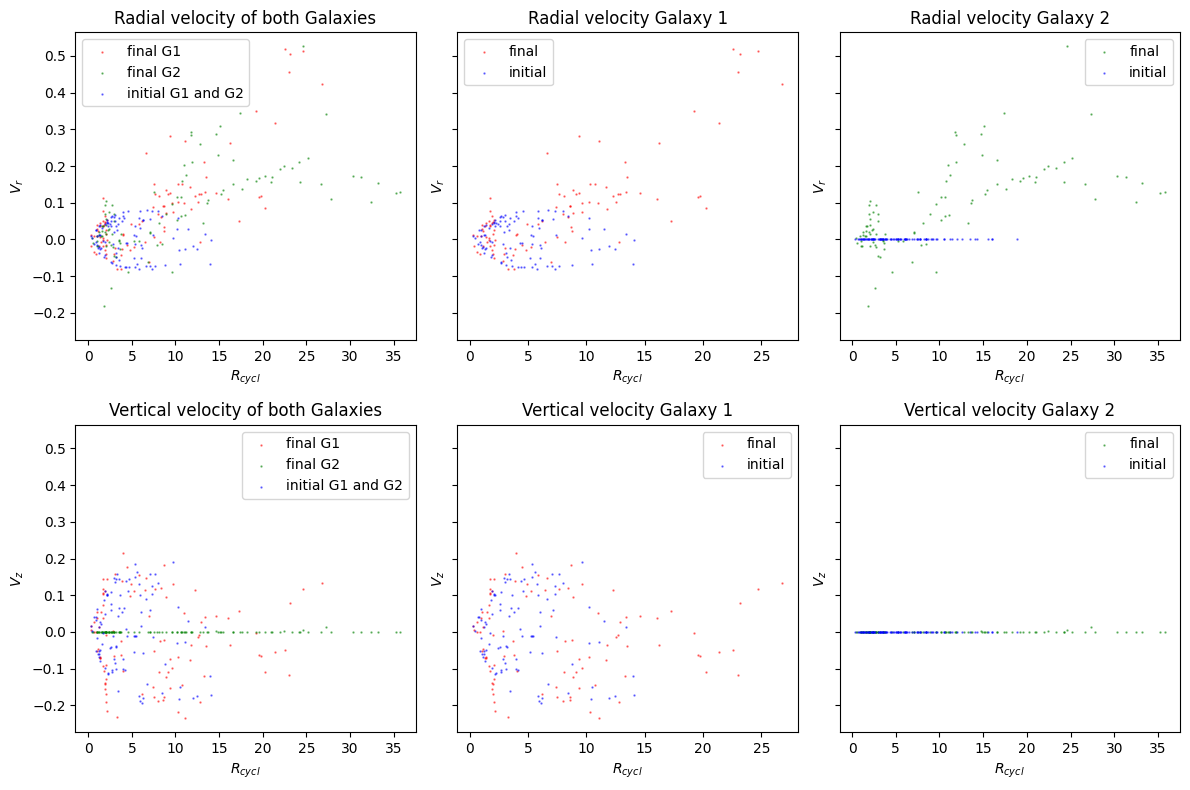

In [38]:
Radial_Vertical_velocity(Combined_Galaxies_inclined_Rcyl, Combined_Galaxies_inclined_Vr, Combined_Galaxies_inclined_Vz, div)

Text(0.5, 1.0, 'Vertical velocity Galaxy 2')

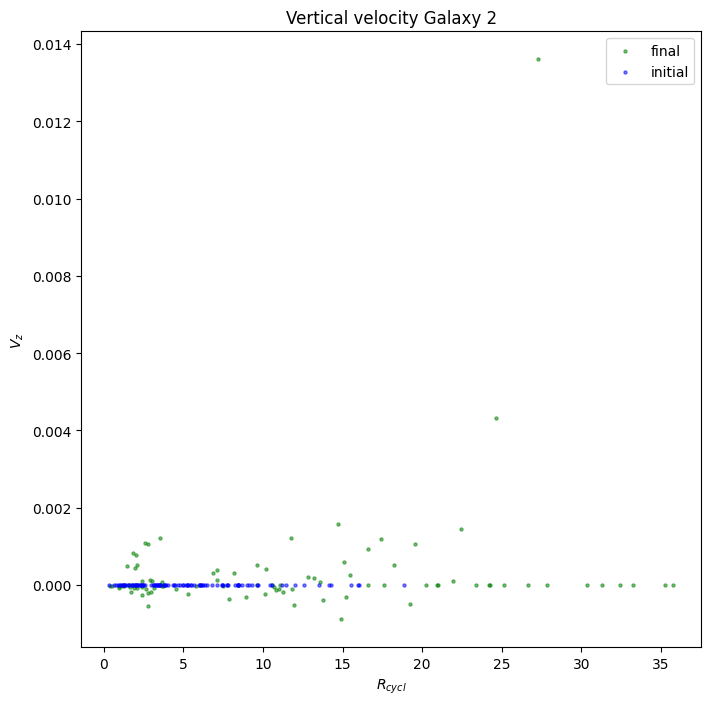

In [40]:
#plotting only the Vz of the second galaxy

plt.figure(figsize=(8,8))
plt.scatter(Combined_Galaxies_inclined_Rcyl[-1,(div+1):], Combined_Galaxies_inclined_Vz[-1,(div+1):], s=5, color='g', label='final', alpha=0.5)
plt.scatter(Combined_Galaxies_inclined_Rcyl[0,(div+1):], Combined_Galaxies_inclined_Vz[0,(div+1):], s=5, color='b', label='initial', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('$R_{cycl}$')
plt.ylabel('$V_{z}$')
plt.title('Vertical velocity Galaxy 2')

The outcome of this simulation is very similar to the first case invstigated by us: for example, the filamentary structures created here are very similar to the other ones.
Also concerning the evolution of the radial velocity we can say the same things pointed out in the first merger simulation. 
A very interesting thing to notice is that in the final configuration, differently from all the other cases, the final vertical velocity of the galaxy in the *x-y* plane has some non null values, even if very small. This is because, while the two galactic centers remain in the same plane $(x-y)$, there are some particles belonging to the disk that do not lay in that same plane. These particles contribute very little to the total acceleration. Thanks to their cntribution I can justify the small variation of the vertical velocity for the final configuration of the galaxy.

---

# 7 - CONCLUSIONS

With this project it was possible to have a very simplified overview of how two galaxies mutually interacting evolve with time. After checking the stability of one galaxy alone, its rotation curve and its surface density profile, we created a second galaxy, equal to the first one but translated and with an initial velocity different from zero. Then, we simulated three galactic encounters. The first one was an encounter between two galaxies rotating in the same direction and laying in the same plane; the second was an encounter between two galaxies rotating in opposite directions, and the third one was an encounter between two galaxies rotating in the same direction and laying in different planes. All the simulation was integrated in a time equal to two times the rotation period of the galaxy itself. \
From these simulations we obtained the formation of well defined structures in all the three cases, that we associated with stellar currents. The counter-rotating case highlighted a more complicated structure; in particular, while one galaxy still shows two well defined elongated structures, for the second galaxy structures are not straightforward to recognize. Finally, in the inclined case, beside the formation of clear structures the most noticeable thing was the appearence of a new component for the velocity along z, since the problem passed from being 2D to being 3D. 

We can finally think of some implementation to this problem that can be done. In particular:
- we could think of considering an additional velocity gaussian component due to random motions when generating the initial condition; this should be quite straightforward to implement;
- we could think of adding some new components to the galaxies, for example a NFW potential for the DM halo, an Hernquist potential for the bulge and a Miyamoto-Nagai potential for the disk. Anyway, This is a trifle more complicated because we also have to account that the potential is moving with the galaxy, so we need to implement a potential which position is varying in time. Furthermore, we have to insert these potentials both in the initial conditions generator and in the algoritm to compute the acceleration. 

Overall, we recognize that this is a very simplified model for a galaxy for many reasons, for example that considers the all mass centered in the centre, which is the source of a Plummer potential, or that we did not consider any other component (dark matter halo, bulge, bars...) ecc... Anyway, with all this in mind, the outcomes of the simulations still give a first idea of how a galactic encounter works. 